In [88]:
import torchvision.models as models
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
from torchvision import transforms
from torch.autograd import Variable
import torch.nn.functional as F

In [89]:
model = models.resnet50()

In [90]:
model.conv1 = torch.nn.Conv2d(1,64,7,2,3)
model.fc = torch.nn.Linear(2048,2)

In [91]:
model.load_state_dict(torch.load('./data/resnet.pt'))

<All keys matched successfully>

In [92]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [93]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('L')

In [121]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])    

    return transf

def get_preprocess_transform():
    grayscale_mean = sum([0.485, 0.456, 0.406]) / 3.0
    grayscale_std = sum([0.229, 0.224, 0.225]) / 3.0
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[grayscale_mean], std=[grayscale_std])
    ])

In [122]:
def batch_predict(images):
    images = np.array(images)
    if images.shape[-1] == 3:
        images = np.mean(images, axis=-1, keepdims=True)

    images = [preprocess_transform(Image.fromarray(image.squeeze())).numpy() for image in images]
    batch = torch.tensor(images, dtype=torch.float32)
    batch = batch.to(device)

    with torch.no_grad():
        logits = model(batch)
        probs = F.softmax(logits, dim=1)

    return probs.detach().cpu().numpy()

In [123]:
img = get_image('./data/valid_opacity_0100.jpg')

In [124]:
test_pred = batch_predict(np.array([np.array(pill_transf(img))]))
print(test_pred.squeeze().argmax())

1


In [125]:
from lime import lime_image

In [136]:
transformed_img = pill_transf(img) 

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(transformed_img), 
                                         batch_predict, 
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000)

100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 112.80it/s]


In [137]:
from skimage.segmentation import mark_boundaries

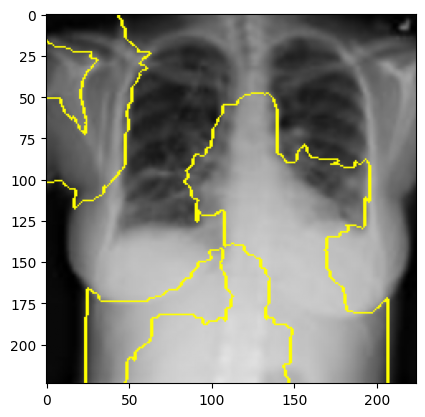

In [138]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

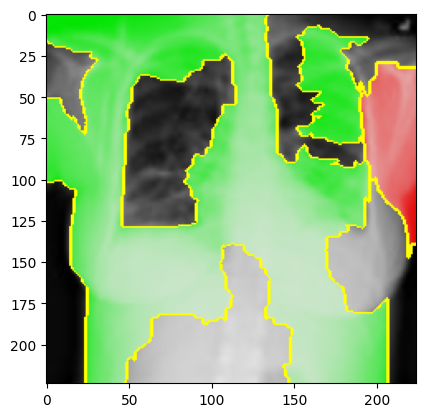

In [139]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)

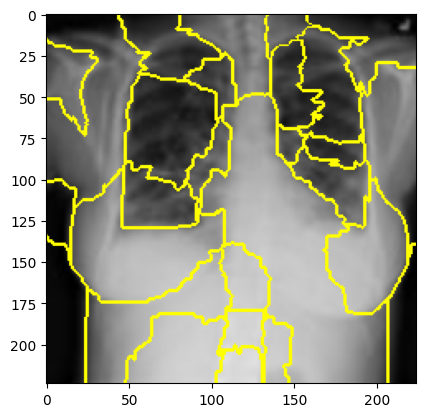

In [140]:
plt.imshow(mark_boundaries(np.array(transformed_img), explanation.segments))
plt.show()

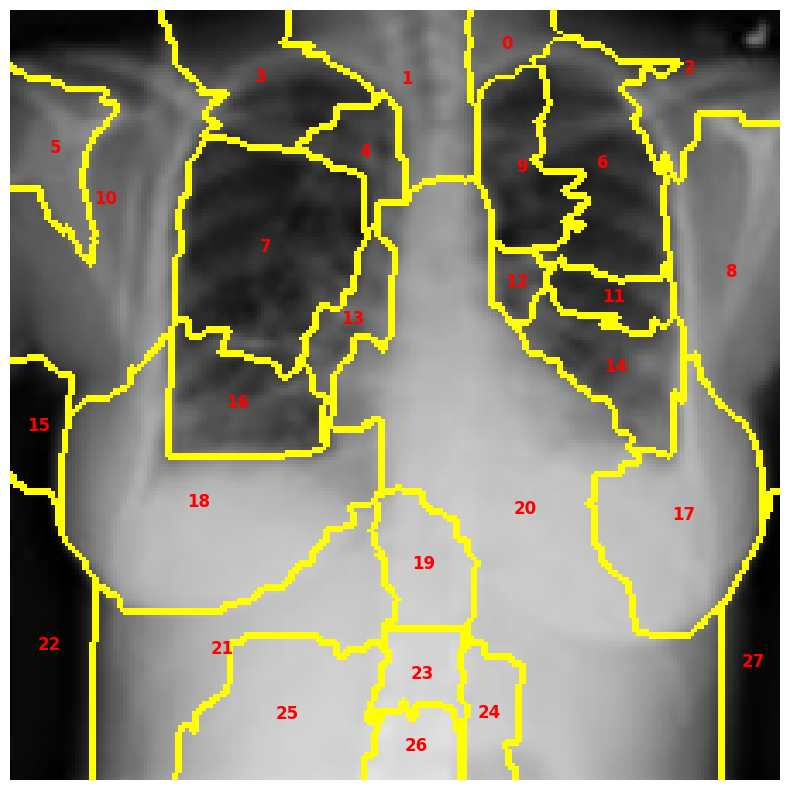

In [141]:
from scipy.ndimage import center_of_mass

segments = explanation.segments

boundary_marked_image = mark_boundaries(np.array(transformed_img), segments)

plt.figure(figsize=(10,10))
plt.imshow(boundary_marked_image)

unique_segments = np.unique(segments)
for seg_id in unique_segments:
    y, x = center_of_mass(segments == seg_id)
    plt.text(x, y, str(seg_id), color='red', fontsize=12, ha='center', va='center', weight='bold')

plt.axis('off')
plt.show()


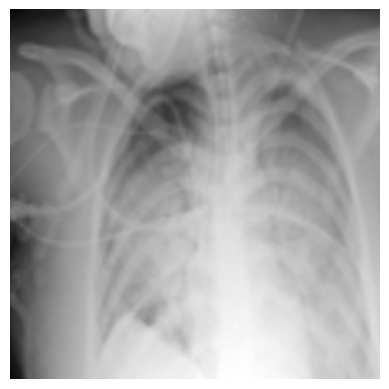

In [76]:
unique_segments = np.unique(explanation.segments)

masked_image = np.ones(np.array(transformed_img).shape) * 0.5
for sp_id in unique_segments:
    masked_image[segments == sp_id] = np.array(transformed_img)[segments == sp_id]

plt.imshow(masked_image, cmap='gray')
plt.axis('off')
plt.show()

In [134]:
masked_tensor = preprocess_transform(Image.fromarray((masked_image.squeeze() * 255).astype(np.uint8))).unsqueeze(0).to(device)

with torch.no_grad():
    logits = model(masked_tensor)
    probs = F.softmax(logits, dim=1)
prediction = probs.cpu().numpy()[0]

print(prediction)

[0. 1.]


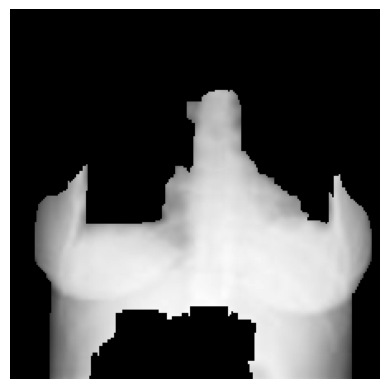

In [113]:
segments = explanation.segments

desired_superpixels = [17, 18, 19, 20, 21]

masked_image = np.ones(np.array(transformed_img).shape) * 0.5
for sp_id in desired_superpixels:
    masked_image[segments == sp_id] = np.array(transformed_img)[segments == sp_id]

plt.imshow(masked_image, cmap='gray')
plt.axis('off')
plt.show()

In [119]:
masked_tensor = preprocess_transform(Image.fromarray((masked_image.squeeze() * 255).astype(np.uint8))).unsqueeze(0).to(device)

with torch.no_grad():
    logits = model(masked_tensor)
    probs = F.softmax(logits, dim=1)
prediction = probs.cpu().numpy()[0]

print(prediction)

[0.04317622 0.95682377]


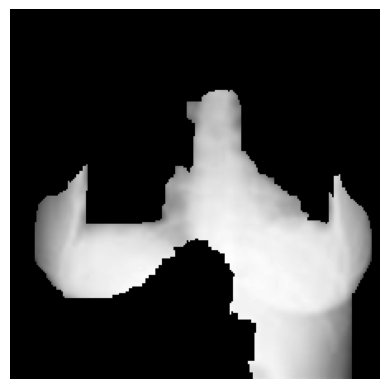

In [122]:
segments = explanation.segments

desired_superpixels = [17, 18, 20]

masked_image = np.ones(np.array(transformed_img).shape) * 0.5
for sp_id in desired_superpixels:
    masked_image[segments == sp_id] = np.array(transformed_img)[segments == sp_id]

plt.imshow(masked_image, cmap='gray')
plt.axis('off')
plt.show()

In [123]:
masked_tensor = preprocess_transform(Image.fromarray((masked_image.squeeze() * 255).astype(np.uint8))).unsqueeze(0).to(device)

with torch.no_grad():
    logits = model(masked_tensor)
    probs = F.softmax(logits, dim=1)
prediction = probs.cpu().numpy()[0]

print(prediction)

[0.6638672  0.33613282]


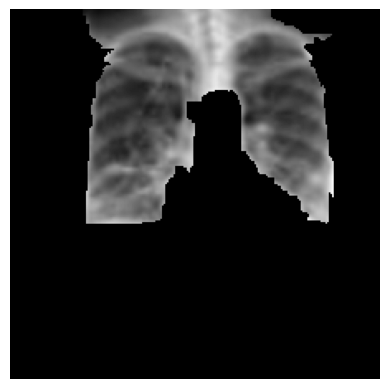

In [124]:
segments = explanation.segments

desired_superpixels = [0, 1, 3, 4, 6, 7, 9, 11, 12, 13, 14, 16]

masked_image = np.ones(np.array(transformed_img).shape) * 0.5
for sp_id in desired_superpixels:
    masked_image[segments == sp_id] = np.array(transformed_img)[segments == sp_id]

plt.imshow(masked_image, cmap='gray')
plt.axis('off')
plt.show()

In [125]:
masked_tensor = preprocess_transform(Image.fromarray((masked_image.squeeze() * 255).astype(np.uint8))).unsqueeze(0).to(device)

with torch.no_grad():
    logits = model(masked_tensor)
    probs = F.softmax(logits, dim=1)
prediction = probs.cpu().numpy()[0]

print(prediction)

[1. 0.]


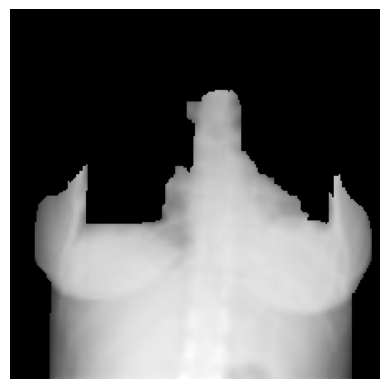

In [127]:
segments = explanation.segments

desired_superpixels = [17, 18, 19, 20, 21, 23, 24, 25, 26]

masked_image = np.ones(np.array(transformed_img).shape) * 0.5
for sp_id in desired_superpixels:
    masked_image[segments == sp_id] = np.array(transformed_img)[segments == sp_id]

plt.imshow(masked_image, cmap='gray')
plt.axis('off')
plt.show()

In [128]:
masked_tensor = preprocess_transform(Image.fromarray((masked_image.squeeze() * 255).astype(np.uint8))).unsqueeze(0).to(device)

with torch.no_grad():
    logits = model(masked_tensor)
    probs = F.softmax(logits, dim=1)
prediction = probs.cpu().numpy()[0]

print(prediction)

[0.01545113 0.9845488 ]
